- Goal
    - Create synthetic data using IDM
    - Learn parameters of that data using particle filtering
    - Aliter 7 Feb: Learn using CEM idea, fitness function and then distb and then sample
- Learning
    - Need at least 2 vehicles so that there is a neighbor in the front
    - Otherwise src/1d/driver/lane_follower_driver errors
    - That is why the `AutomotiveDrivingModels/doc/1DMobius` stuff does 
    not work with 1 car only (needs at least 2 cars)
    - The tutorial does not work with `gen_straight_roadway` because that
    generates a roadway of type AutomotiveDrivingModels.roadway as opposed to
    AutomotiveDrivingModels.StraightRoadway
- Open question
    - IDM won't work unless there is a car in front (errors saynig nothing in sight)
    - We are focusing on learning the params of the second car here. Is that sound sensible?
- Flow of code
    - Call the required `usings`
    - Define functions required
    - Actual running things
        - Generate true trajectory
        - Generate a set of particles uniformly between sensible range of values
        - Compute fitness, sort and select numtop
        - Fit a distribution over this
        - Resample particles
- Scenario
    - Slower car in front (car 1)
    - Faster car behind (car 2)
    - We want to estimate params of car 2
- Feb 10: Adding timegap_des as our 2nd param in the 2 car, 1D, IDM scenario
    - Make code capable of handling 2d param. So far, had only scalar param
    i.e v_des
    - Fitting 2D distributions is required now
- Feb 22
    - the `rec` generated using `simulate` is a devious monster
    - It stores the last timestep in the 1st entry and first timestep in last entry
    - Be careful
- Mar 27
    - Inspired by behavior test written by Maxime to convert this code to work with general scene
    instead of scene1D and state1D as previously
    - Scaling up: scenario is to have 3 different speed vehicles starting in adjacent lanes. Each
    car will have an associated bucket of particles and at the end we whould be able to uncover
    true params for all three cars
    - Disclaimer: This will definitely work since we have confirmed that we can uncover params for one 
    car when it is the leader (i.e. unaffected by any car in front). The current exercise is to scale up the
    code to work with multiple vehicles
    - Idea is that every vehicles associated bucket of particles will evolve differently as it sees more
    of the true trajectory. This is in contrast to original idea where we thought we will have all the buckets
    pooled together to inform the final distribution

In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reel
using Interact
using StatsBase # For random particle generation
using Test
using Distributions
using Pkg

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ac92513fc97126f4d4502d0637c43de8cdb5fca9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ac92513fc97126f4d4502d0637c43de8cdb5fca9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
include("admin_functions.jl")
include("driving_functions.jl")
# include("filtering_functions.jl")

"Hallucinate a step forward given a specific car\n---------Arguments:\n`scene` Scene to start hallucination from\n`particle` Dict with key as IDM parameter name and value as param val\n`car_id` Identity of the car of interest\n\n-------Returns: Hallucinated position of car of interest\n\n---------NOTES:------------\n- For now, we hallucinate the car of interest with the particle. Other cars are assumed to be\ndriving with IDM(v_des = 10). They don't matter in the particle update of the car of interest\n(FOR NOW)\n- We return only the position of the car along the lane. We don't even return which lane it is\nin information. In the future, we want to return 2D position and measure 2D likelihood value somehow\n"

In [3]:
# List the available functions loaded from the above include statements
# https://stackoverflow.com/questions/21301451/get-a-list-of-current-variables-in-julia-lang
names(Main)[4:end]

6-element Array{Symbol,1}:
 :gen_test_particles       
 :generate_ground_truth    
 :init_car_particle_buckets
 :init_scene_roadway       
 :to_dict_form             
 :to_matrix_form           

In [11]:
function hallucinate_a_step(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    # Hope is that scene_input does not get modified doing the simulate
    # Extremely crucial step. Not doing the deepcopy was the problem
    # scene was being propagated forward and therefore for every other
    # candidate particle, the hallucination was starting from hallucinated scene
    # resulting from previous particle
    scene = deepcopy(scene_input)
    n_cars = scene.n 

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for i in 1:n_cars
        if i == car_id
            models[i] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles in the hallucination
            models[i] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.1
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
        for c in car_id:car_id
            s = f.entities[c].state.posF
            X[t, 1] = s.s #position
        end
    end
    return X[1]
end

hallucinate_a_step (generic function with 1 method)

In [13]:
function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    timestep = 0.1 #TODO: Remove hardcoding
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    
    f_frozen = f
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
        # TODO: This math needs to be verified from random variable calculations
        std_dev_pos = timestep*timestep*std_dev_acc
#         @show f_frozen.entities[1].state.posF.s    
        hpos = hallucinate_a_step(roadway,f_frozen,p_dict,car_id=car_id)
#         @show "compute speaks"
#         @show hpos
#         @show trupos
        
        lkhd_vec[i] = pdf(Normal(hpos,std_dev_pos),trupos[1])
    end
    return lkhd_vec,p_mat,params
end

compute_particle_likelihoods (generic function with 1 method)

In [14]:
# Test: compute_particle_likelihoods
num_p = 3 # number of particles
car_pos = [0.]
n_cars = length(car_pos) # number of cars
scene,roadway = init_scene_roadway(car_pos)
d1 = Dict(:v_des=>25.0,:σ=>0.1)
car_particles = [d1]
car_vel_array = [25.]
rec = generate_ground_truth(car_pos,car_particles,car_vel_array=car_vel_array,n_steps=10)

# loop over the trajectory step by step
f_end_num = length(rec.frames)

bucket_array = init_car_particle_buckets(n_cars,num_p)
    
for t in 1:f_end_num-1
    if t%10==0 @show t end
    f = rec.frames[f_end_num - t + 1]
    
    for car_id in 1:n_cars
        old_p_set_dict = bucket_array[car_id]
        trupos = rec.frames[f_end_num-t].entities[car_id].state.posF.s
#         @show "outeloop_speaks"
#         @show trupos
#         @show old_p_set_dict
        new_p_set_dict = update_p_one_step(roadway,f,trupos,old_p_set_dict,car_id=car_id,approach="pf")
        bucket_array[car_id] = new_p_set_dict
    end
end  
#@show fit(MvNormal,old_p_mat) # Don't work because all elements identical
@show bucket_array

vcat(p_mat, lkhd_vec') = [26.0 22.0 26.0; 0.2 0.6 0.1; 14.0946 6.91146 0.000434519]
p_weight_vec = [0.670964, 0.329015, 2.0685e-5]
vcat(p_mat, lkhd_vec') = [22.0 26.0 22.0; 0.6 0.2 0.6; 3.23267 1.23367 6.20777]
p_weight_vec = [0.302851, 0.115576, 0.581573]
vcat(p_mat, lkhd_vec') = [22.0 22.0 22.0; 0.6 0.6 0.6; 3.56787 7.9222 0.114981]
p_weight_vec = [0.307441, 0.682651, 0.00990781]
vcat(p_mat, lkhd_vec') = [22.0 22.0 22.0; 0.6 0.6 0.6; 0.946442 1.71482 0.990453]
p_weight_vec = [0.259177, 0.469593, 0.27123]
vcat(p_mat, lkhd_vec') = [22.0 22.0 22.0; 0.6 0.6 0.6; 0.45646 0.545665 3.34405]
p_weight_vec = [0.105026, 0.125551, 0.769424]
vcat(p_mat, lkhd_vec') = [22.0 22.0 22.0; 0.6 0.6 0.6; 1.93299 1.21963 8.83546]
p_weight_vec = [0.161243, 0.101737, 0.73702]
vcat(p_mat, lkhd_vec') = [22.0 22.0 22.0; 0.6 0.6 0.6; 9.98443 3.52831 0.994241]
p_weight_vec = [0.68825, 0.243215, 0.0685354]
vcat(p_mat, lkhd_vec') = [22.0 22.0 22.0; 0.6 0.6 0.6; 0.0734227 0.224849 5.16349]
p_weight_vec = [0.013443, 

1-element Array{Dict,1}:
 Dict{Any,Any}(:v_des=>[22.0, 22.0, 22.0],:σ=>[0.6, 0.6, 0.6])

In [16]:
"""
update_p_one_step: Update particles given one step of true data

------------Arguments that need explanation:
`p_set_dict` Dictionary with parameters of IDM as keys and associated value as array of particles
`f` Frame to start hallucination from
`trupos` Resulting true position starting from frame f
`approach` Select "pf" or "cem"
`elite_fraction_percent` Required for the cem method to fit a distribution

------------Other functions called:`compute_particle_likelihoods`

------------Returns:
`new_p_set_dict` Dictionary with keys as IDM parameters and values as array of particles

-----------NOTES
- This function updates associated particles over 1 step for one car
- I think frame and scene can be used as the same thing. Maybe techincally scene is an array
with each element in that array being a frame.
- This function will be called by a function that loops over all the cars present in a scene
"""
function update_p_one_step(roadway,f,trupos,p_set_dict;
                            car_id=-1,approach="pf",elite_fraction_percent=20)
    if car_id==-1 @show "Provide valid car_id" end
    
    lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,f,trupos,p_set_dict,car_id=car_id)
#     @show vcat(p_mat,lkhd_vec')
    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]
    
    if approach=="pf"
        p_weight_vec = weights(lkhd_vec./sum(lkhd_vec)) # Convert to weights form to use julia sampling
#         @show p_weight_vec
        idx = sample(1:num_p,p_weight_vec,num_p)
        new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    end
    
    if approach=="cem"
        sortedidx = sortperm(lkhd_vec,rev=true)
        numtop = convert(Int64,ceil(num_p*elite_fraction_percent/100.0))
        best_particles = p_mat[:,sortedidx[1:numtop]] # elite selection
#         @show best_particles
        p_distribution = fit(MvNormal,best_particles) # fit distb using elites
        new_p_mat = rand(p_distribution,num_p) # sample num_p new particles from dist
    end
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict
end

update_p_one_step

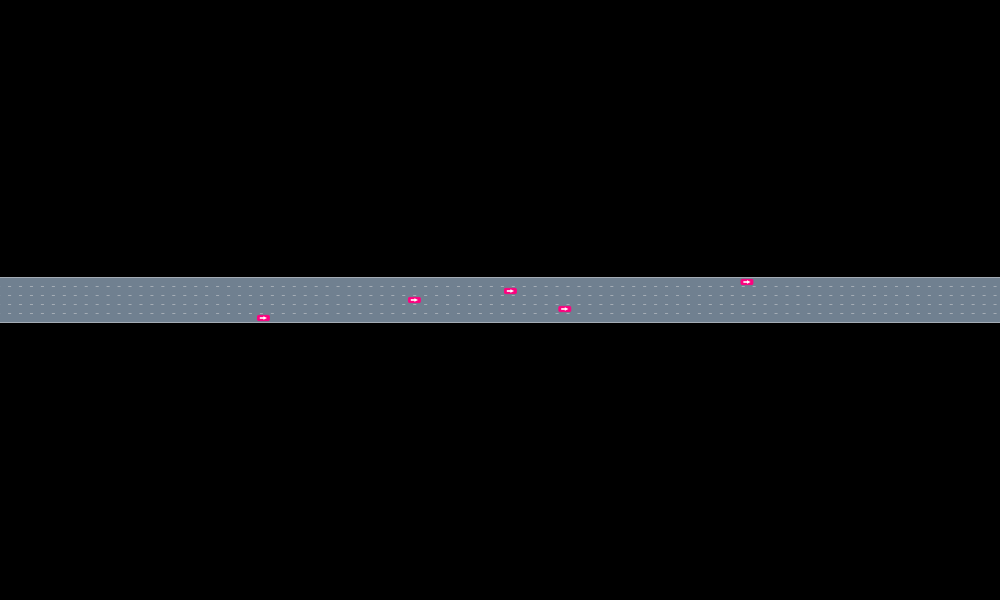

In [45]:
car_pos = [0.,0.,0.,0.,0.]

n_cars = length(car_pos) # number of cars
scene,roadway = init_scene_roadway(car_pos)
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)

car_particles = [d1,d2,d3,d4,d5]

car_vel_array = [10.,20.,15.,20.,20.]

rec = generate_ground_truth(car_pos,car_particles,car_vel_array=car_vel_array,n_steps=100)
render(rec.frames[1],roadway)

In [41]:
num_p = 100 # number of particles
car_pos = [0.,0.,0.,0.,0.]

n_cars = length(car_pos) # number of cars
scene,roadway = init_scene_roadway(car_pos)
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)

car_particles = [d1,d2,d3,d4,d5]

car_vel_array = [10.,20.,15.,20.,20.]

rec = generate_ground_truth(car_pos,car_particles,car_vel_array=car_vel_array,n_steps=100)

# loop over the trajectory step by step
f_end_num = length(rec.frames)

bucket_array = init_car_particle_buckets(n_cars,num_p)
    
for t in 1:f_end_num-1
    if t%10==0 @show t end
    f = rec.frames[f_end_num - t + 1]
    
    for car_id in 1:n_cars
        old_p_set_dict = bucket_array[car_id]
        trupos = rec.frames[f_end_num-t].entities[car_id].state.posF.s
#         @show trupos
#         @show old_p_set_dict
        new_p_set_dict = update_p_one_step(roadway,f,trupos,old_p_set_dict,car_id=car_id,approach="pf")
        bucket_array[car_id] = new_p_set_dict
    end
end  
#@show fit(MvNormal,old_p_mat) # Don't work because all elements identical
for i in 1:length(bucket_array)
    params = []
    for (k,v) in bucket_array[i]
        push!(params,mean(v))
    end
    @show params
end

t = 10
t = 20
t = 30
t = 40
t = 50
t = 60
t = 70
t = 80
t = 90
params = Any[10.0, 0.1]
params = Any[20.0, 0.1]
params = Any[15.0, 0.4]
params = Any[18.0, 0.4]
params = Any[29.0, 0.1]


# Tests: Serve as function calling examples

# Visualize

In [ ]:
# Function: Return rec corresponding to generated traj
    # Will help visualizatoin
    # Calls init_scene
# Might be useful later
    # models[2] = IntelligentDriverModel(v_des=particle[1],s_min=particle[2],T=particle[3])
function gen_rec4vid(particle;nticks=100,timestep=0.1)
    scene = init_scene()
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=particle[1],σ = particle[2])
    models[2] = IntelligentDriverModel(v_des=12.0)

    # Simulate for nticks (default 100) time steps
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)

    return rec
end

In [ ]:
# overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true,
#         pos=VecE2(veh.state.s-0.7, 3)) for veh in scene];
# render(scene, roadway, overlays, cam=cam, canvas_height=100)

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
true_rec = gen_rec4vid([20.0 0.1],nticks=100)
rec = true_rec
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam, canvas_height=100)
end

# LEARNING AND EXPERIMENTATION

In [ ]:
# LEARNING ABOUT MULTIDIM DISTB
# Test: Generate samples for a 2d distb
d2 = MvNormal(2,2.0) # first arg shows dimension, second shows std dev
qw = rand(d2,6) # Will generate 6 samples i.e. 6 columns

# Test: Fit 2d distribution
dx = Normal()
dy = Normal(2,1.0)
x = rand(dx,100)
y = rand(dy,100)

# Matrix with each column being a sample
# Total columns is total number of samples
# Total rows is number of parameters
# All entries in a row contain value from same param eg:v_des
data_matrix = vcat(x',y')
fit(MvNormal,data_matrix)

In [ ]:
using PyPlot

In [ ]:
num_samples = 2000
y1 = rand(Normal(10.0,5.0),num_samples)
y2 = rand(Normal(2.0,1.0),num_samples)
plot(1:num_samples,y1)
plot(1:num_samples,y2)

In [ ]:
using StatPlots

In [ ]:
StatPlots.plot(Normal(3,5),linewidth=4,size=(2500,2500))

In [ ]:
roadway = gen_straight_roadway(2,1000.0);

In [ ]:
scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)